**Introduction to Artificial Neural Networks with Keras**

In [8]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [9]:
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:,(2,3)]
y = (iris.target == 0).astype(np.int32)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

Saving figure perceptron_iris_plot


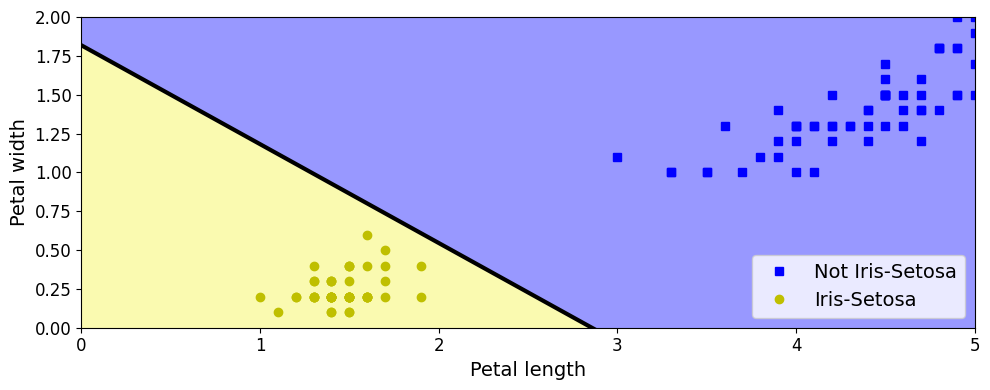

In [10]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

In [11]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


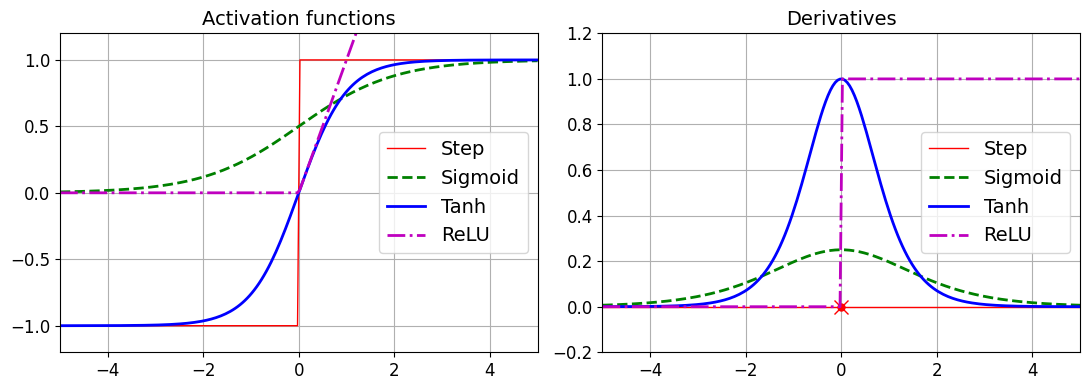

In [12]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

In [13]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

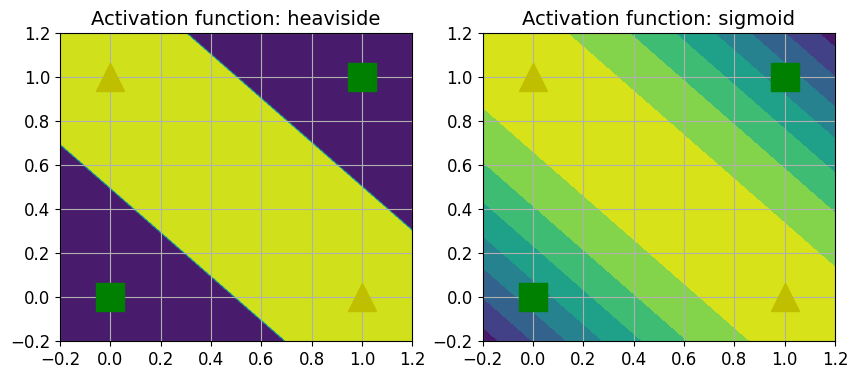

In [14]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

### ***Image Classification***

In [15]:
import tensorflow as tf
from tensorflow import keras

In [16]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [17]:
X_train_full.shape

(60000, 28, 28)

In [18]:
X_train_full.dtype

dtype('uint8')

In [19]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:]/255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255

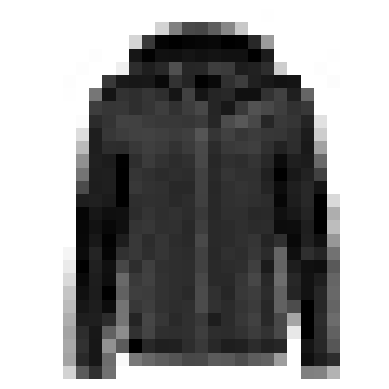

In [20]:
plt.imshow(X_train[0], cmap='binary')
plt.axis('off')
plt.show()

In [21]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [22]:
class_names = ['T_shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

In [23]:
class_names[y_train[0]]

'Coat'

In [24]:
X_valid.shape

(5000, 28, 28)

In [25]:
X_test.shape

(10000, 28, 28)

Saving figure fashion_mnist_plot


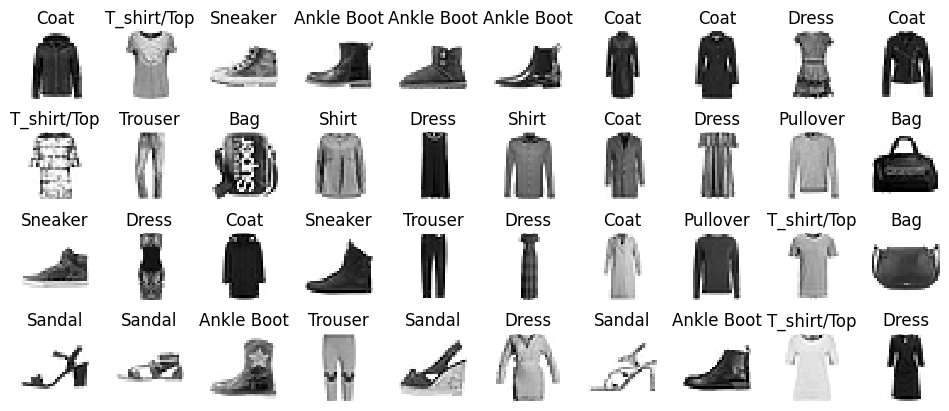

In [26]:
n_cols = 10
n_rows = 4
plt.figure(figsize=(n_cols*1.2, n_rows*1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize = 12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig("fashion_mnist_plot", tight_layout=False)
plt.show()


In [27]:
keras.backend.clear_session()

In [28]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=[28, 28]),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])


In [29]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

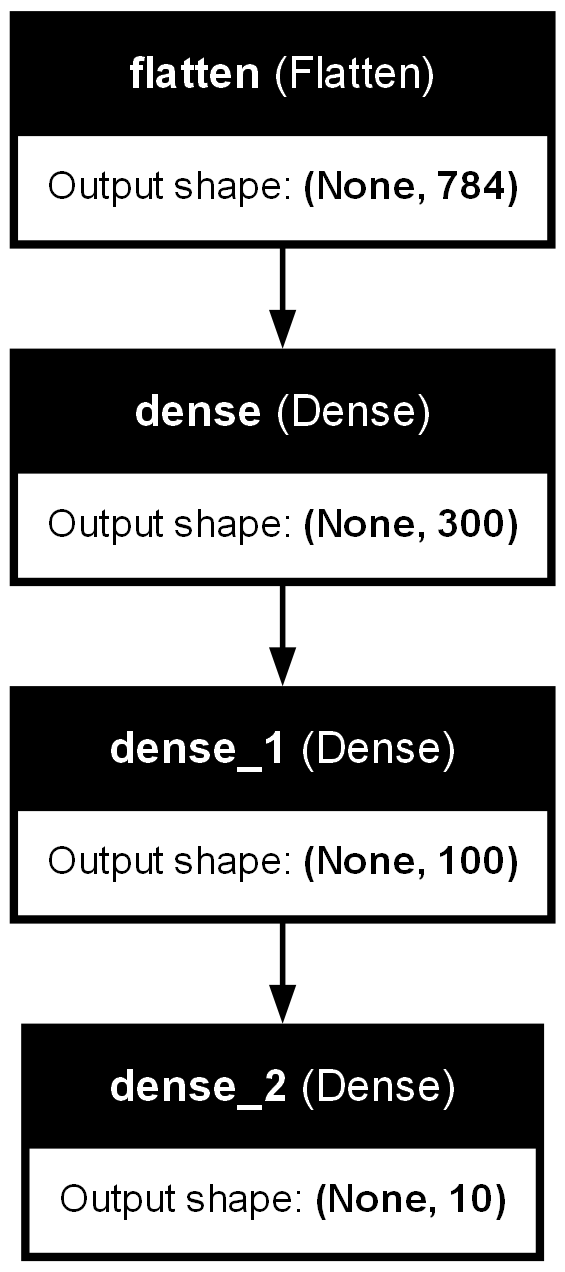

In [31]:
keras.utils.plot_model(model, 'Fashion_mnist_model.png', show_shapes=True, show_layer_names=True)

In [32]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [33]:
model.get_layer(hidden1.name) is hidden1

True

In [34]:
weights, biases = hidden1.get_weights()

In [35]:
weights

array([[-0.04819295, -0.06365117,  0.06324379, ...,  0.03697161,
         0.06406115, -0.00447654],
       [ 0.06833389, -0.03268226, -0.06070082, ..., -0.00531877,
        -0.01420297, -0.04409631],
       [ 0.02512826,  0.05766562,  0.01909601, ..., -0.02919337,
         0.07368404,  0.02380351],
       ...,
       [ 0.02809834, -0.06286641, -0.02318229, ...,  0.00418977,
         0.01875453, -0.05176087],
       [ 0.06039101, -0.00680286, -0.05798847, ..., -0.00199093,
         0.0463138 ,  0.05745997],
       [ 0.00107046,  0.03101622, -0.01601913, ...,  0.04760125,
         0.01819524, -0.06047925]], dtype=float32)

In [36]:
weights.shape

(784, 300)

In [37]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [38]:
biases.shape

(300,)

In [39]:
model.compile()

In [40]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'sgd',
              metrics = ['accuracy'])

In [41]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data =(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6805 - loss: 1.0170 - val_accuracy: 0.8348 - val_loss: 0.5017
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8215 - loss: 0.5060 - val_accuracy: 0.8508 - val_loss: 0.4454
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8402 - loss: 0.4558 - val_accuracy: 0.8600 - val_loss: 0.4151
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8512 - loss: 0.4255 - val_accuracy: 0.8640 - val_loss: 0.3966
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8593 - loss: 0.3988 - val_accuracy: 0.8674 - val_loss: 0.3869
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8647 - loss: 0.3883 - val_accuracy: 0.8676 - val_loss: 0.3744
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8683 - loss: 0.3738 - val_accuracy: 0.8686 - val_loss: 0.3694
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8737 - loss: 0.3569 - 

In [42]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [43]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [44]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Saving figure keras_learning_curves_plot


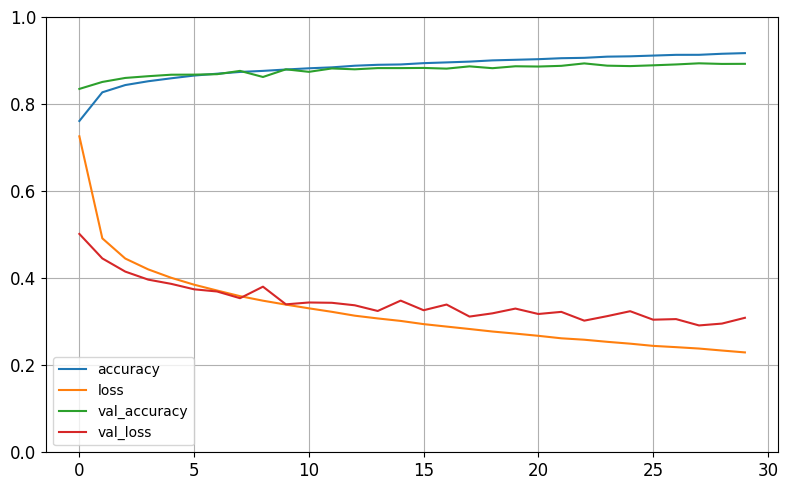

In [45]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig('keras_learning_curves_plot')
plt.show()

In [46]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8835 - loss: 0.3383


[0.34328916668891907, 0.8810999989509583]

In [47]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [48]:
y_pred = np.argmax(model.predict(X_new), axis=1)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([9, 2, 1], dtype=int64)

In [49]:
np.array(class_names)[y_pred]

array(['Ankle Boot', 'Pullover', 'Trouser'], dtype='<U11')

In [50]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_image_plot


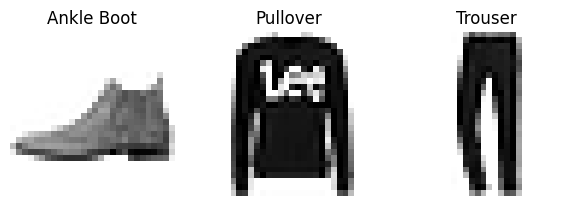

In [51]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap='binary', interpolation='nearest')
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize = 12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_image_plot', tight_layout=False)
plt.show()

In [52]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

In [54]:
keras.layers.InputLayer(shape=[28, 28])

<InputLayer name=input_layer_1, built=True>

In [55]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=X_train.shape[1:]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7225 - val_loss: 1.8749
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1662 - val_loss: 0.8466
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.8517 - val_loss: 0.7013
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 0.7595 - val_loss: 0.6535
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - loss: 0.7130 - val_loss: 0.6218
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 0.6802 - val_loss: 0.5968
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - loss: 0.6540 - val_loss: 0.5758
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 0.6312 - val_loss: 0.5567
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 0.6107 - val_loss: 0.5394
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 0.5930 - val_loss: 0.5239
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - loss: 0.5775 - val_loss: 0.5096
Epoch 12/20
363/363 ━━━━━━━━━━━━━━

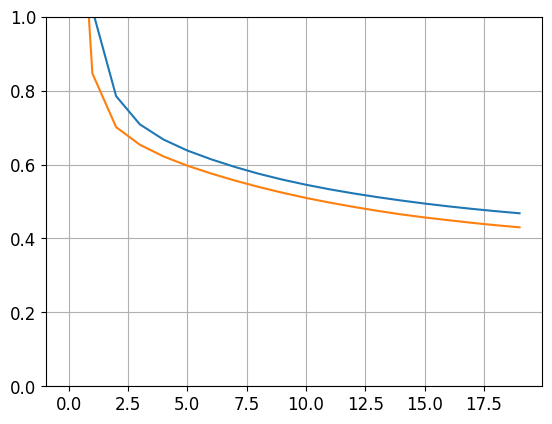

In [56]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [57]:
y_pred

array([[0.4356984],
       [1.7599297],
       [2.9156053]], dtype=float32)

### Functional API

In [58]:
np.random.seed(42)
tf.random.set_seed(42)

In [59]:
keras.backend.clear_session()

In [60]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs =[input_], outputs = [output])

In [61]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,239 (4.84 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data = (X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.1575 - val_loss: 0.9456
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7983 - val_loss: 0.6809
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7116 - val_loss: 0.6329
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6621 - val_loss: 0.5940
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.6250 - val_loss: 0.5623
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.5957 - val_loss: 0.5358
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 0.5719 - val_loss: 0.5136
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5522 - val_loss: 0.4949
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5357 - val_loss: 0.4793
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5217 - val_loss: 0.4662
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5096 - val_loss: 0.4551
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

In [63]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name = 'output')(concat)
model = keras.models.Model(inputs = [input_A, input_B], outputs = [output])

In [64]:
model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data = ((X_valid_A, X_valid_B), y_valid))
msa_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.8305 - val_loss: 2.0746
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8718 - val_loss: 0.6853
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7021 - val_loss: 0.5967
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6480 - val_loss: 0.5598
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6147 - val_loss: 0.5323
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5885 - val_loss: 0.5095
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5662 - val_loss: 0.4900
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5467 - val_loss: 0.4733
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5298 - val_loss: 0.4592
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5155 - val_loss: 0.4480
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5034 - val_loss: 0.4389
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [65]:
input_A = keras.layers.Input(shape=[5], name='wide_input')
input_B = keras.layers.Input(shape=[6], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name = 'main_output')(concat)
aux_output = keras.layers.Dense(1, name = 'aux_output')(hidden2)
model = keras.models.Model(inputs = [input_A, input_B],
                           outputs = [output, aux_output])

In [66]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [67]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5909 - val_loss: 2.0903
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0216 - val_loss: 1.4057
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8820 - val_loss: 1.3214
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8173 - val_loss: 1.1870
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7736 - val_loss: 1.0468
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7392 - val_loss: 0.9529
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7082 - val_loss: 0.8441
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6804 - val_loss: 0.7706
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6565 - val_loss: 0.7122
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6362 - val_loss: 0.6581
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6192 - val_loss: 0.6183
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [68]:
total_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 0.5044


In [69]:
total_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - loss: 0.5044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [70]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [71]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.5356 - val_loss: 1.2558
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1679 - val_loss: 0.8776
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8572 - val_loss: 0.7794
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7471 - val_loss: 0.7201
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6900 - val_loss: 0.6658
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6515 - val_loss: 0.6172
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6220 - val_loss: 0.5770
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5984 - val_loss: 0.5464
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5791 - val_loss: 0.5254
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5634 - val_loss: 0.5118
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 0.5240
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


In [72]:
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [73]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.6810 - val_loss: 1.8128
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 1.0799 - val_loss: 0.7748
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 0.7784 - val_loss: 0.6600
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.6883 - val_loss: 0.5971
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.6470 - val_loss: 0.5610
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6182 - val_loss: 0.5356
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.5940 - val_loss: 0.5142
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5727 - val_loss: 0.4952
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.5534 - val_loss: 0.4769
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5353 - val_loss: 0.4615
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 0.4987


In [74]:
model.save("my_model.keras")

In [75]:
model = keras.models.load_model('my_model.keras')

In [76]:
model.predict(X_new)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([[0.9284053],
       [1.3103149],
       [2.9400997]], dtype=float32)

In [77]:
model.save_weights('my_model.keras.weights.h5')

In [78]:
model.load_weights('my_model.keras.weights.h5')

In [79]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [80]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [81]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.keras", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_model.keras") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5327 - val_loss: 1.0068
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9353 - val_loss: 0.7713
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7755 - val_loss: 0.7061
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6939 - val_loss: 0.6533
Epoch 5/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6375 - val_loss: 0.6018
Epoch 6/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5937 - val_loss: 0.5544
Epoch 7/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5585 - val_loss: 0.5130
Epoch 8/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5300 - val_loss: 0.4802
Epoch 9/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5074 - val_loss: 0.4556
Epoch 10/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4895 - val_loss: 0.4375
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.4499


In [82]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4751 - val_loss: 0.4247
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 0.4634 - val_loss: 0.4160
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.4538 - val_loss: 0.4099
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.4457 - val_loss: 0.4053
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4387 - val_loss: 0.4004
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4326 - val_loss: 0.3959
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4272 - val_loss: 0.3917
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4223 - val_loss: 0.3881
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.4179 - val_loss: 0.3849
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 0.4140 - val_loss: 0.3821
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4103 - val_loss: 0.3797
Epoch 12/100
363/363 ━━━━━━━━━━

In [83]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [84]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

362/363 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 0.3417
val/train: 0.98
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3416 - val_loss: 0.3233


### TensorBoard

In [85]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [86]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\my_logs\\run_2024_03_23-13_34_34'

In [87]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [88]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [89]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7571 - val_loss: 1.9072
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.8463 - val_loss: 0.7049
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7501 - val_loss: 0.6449
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6937 - val_loss: 0.5991
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6476 - val_loss: 0.5594
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6070 - val_loss: 0.5249
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5716 - val_loss: 0.4965
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5413 - val_loss: 0.4736
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5154 - val_loss: 0.4560
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4936 - val_loss: 0.4424
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4757 - val_loss: 0.4365
Epoch 12/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [90]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 20496), started 0:25:58 ago. (Use '!kill 20496' to kill it.)

In [91]:
run_logdir2 = get_run_logdir()
run_logdir2

'.\\my_logs\\run_2024_03_23-13_34_51'

In [92]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [93]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

d:\ml-stuff\.venv\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [94]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8607 - val_loss: 9.8557
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4437 - val_loss: 0.4360
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4057 - val_loss: 0.4223
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3817 - val_loss: 0.3637
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3678 - val_loss: 0.5183
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3574 - val_loss: 0.3315
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3509 - val_loss: 0.3254
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3447 - val_loss: 0.3193
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3374 - val_loss: 0.3149
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3331 - val_loss: 0.3097
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3300 - val_loss: 0.3080
Epoch 12/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [95]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [111]:
from scikeras.wrappers import KerasRegressor

def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer) 
    return model


In [119]:
keras_reg = KerasRegressor(model=build_model)

In [121]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.0488 - val_loss: 32.1328
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7341 - val_loss: 3.6265
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5667 - val_loss: 0.8249
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5115 - val_loss: 0.5612
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4849 - val_loss: 0.4797
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4678 - val_loss: 0.4469
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4558 - val_loss: 0.4328
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4472 - val_loss: 0.4275
Epoch 9/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4402 - val_loss: 0.4251
Epoch 10/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4342 - val_loss: 0.4238
Epoch 11/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4291 - val_loss: 0.4228
Epoch 12/100
363/363 ━━━━━━━━━━━━━━━━━━━

ValueError: Could not interpret metric identifier: loss

In [ ]:
mse_test = keras_reg.evaluate(X_test, y_test)

In [ ]:
y_pred = keras_reg.predict(X_new)
y_pred

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2, scoring='accuracy')
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])